# Optical Digit Recognition with Parametric Lines

We model the prior on each digit as a collection of parametric lines
which can be traversed by a parameter $t \in [0, 1]$.

We model the data generating process as follows:
1. Choose a number from (0, 3).
2. For each number, sample the set of lines corresponding to the number.
3. Sample from a normal distribution centered at the point with standard deviation 0.05.

All digits will be in the range [0, 1] on both x and y axes.

In [1]:
using Gen
using Plots
using Printf
using LinearAlgebra

### Define Digit Sampling

In [2]:
mutable struct Digit
    xs::Vector{Float64}
    ys::Vector{Float64}
    lengths::Vector{Float64}   # Will be half as long as xs and ys
end

"Add a segment defined by two points to a digit"
function add_segment!(digit::Digit, p1::Vector{Float64}, p2::Vector{Float64})
    digit.xs = vcat(digit.xs, p1[1], p2[1])
    digit.ys = vcat(digit.ys, p1[2], p2[2])
    digit.lengths = vcat(digit.lengths, norm(p2 - p1))
end

"""
Sample a point along the digit.
t is a float between 0 and 1.
"""
function sample_digit_t(digit::Digit, t::Float64)::Vector{Float64}
    total_length::Float64 = sum(digit.lengths)
    t_length::Float64 = t * total_length
    n_segments = size(digit.lengths)[1]

    for i in 1:n_segments
        if t_length <= digit.lengths[i]
            t_segment = t_length / digit.lengths[i]
            return [digit.xs[2*i-1] + t_segment * (digit.xs[2*i] - digit.xs[2*i-1]),
                    digit.ys[2*i-1] + t_segment * (digit.ys[2*i] - digit.ys[2*i-1])]
        else
            t_length -= digit.lengths[i]
        end
    end
    throw("t out of bounds")
end

sample_digit_t

In [3]:
function get_digit(number::Int64)::Digit
    if number == 0
        xs = [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
        ys = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
        lengths = [1.0, 1.0, 1.0, 1.0]
        digit = Digit(xs, ys, lengths)
    elseif number == 1
        digit = Digit([1.0, 1.0], [0.0, 1.0], [1.0])
    elseif number == 2
        segments = [[1.0, 0.0], [0.0, 0.0],
                    [0.0, 0.0], [0.0, 0.5],
                    [0.0, 0.5], [1.0, 0.5],
                    [1.0, 0.5], [1.0, 1.0],
                    [1.0, 1.0], [0.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 0.5, 1.0, 0.5, 1.0]
        digit = Digit(xs, ys, lengths)
    elseif number == 3
        segments = [[0.0, 0.0], [1.0, 0.0],
                    [1.0, 0.0], [1.0, 1.0],
                    [0.0, 0.5], [1.0, 0.5],
                    [0.0, 1.0], [1.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 1.0, 1.0, 1.0]
        digit = Digit(xs, ys, lengths)
    elseif number == 4
        segments = [[1.0, 0.0], [1.0, 1.0],
                    [0.0, 0.5], [1.0, 0.5],
                    [0.0, 0.5], [0.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 1.0, 0.5]
        digit = Digit(xs, ys, lengths)
    elseif number == 5
        segments = [[0.0, 0.0], [1.0, 0.0],
                    [1.0, 0.0], [1.0, 0.5],
                    [0.0, 0.5], [1.0, 0.5],
                    [0.0, 0.5], [0.0, 1.0],
                    [0.0, 1.0], [1.0, 1.0]]
        xs = map(x -> x[1], segments)
        ys = map(x -> x[2], segments)
        lengths = [1.0, 0.5, 1.0, 0.5, 1.0]
        digit = Digit(xs, ys, lengths)
    # elseif number == 6
    #     segments = [[0.0, 0.0], [0.0, 1.0],
    #                 [0.0, 0.0], [1.0, 0.0],
    #                 [1.0, 0.0], [1.0, 0.5],
    #                 [1.0, 0.5], [0.0, 0.5],
    #                 [0.0, 1.0], [1.0, 1.0]]
    #     xs = map(x -> x[1], segments)
    #     ys = map(x -> x[2], segments)
    #     lengths = [1.0, 1.0, 0.5, 1.0, 1.0]
    #     digit = Digit(xs, ys, lengths)
    else
        throw("Digit not supported")
    end
    return digit
end

@gen function sample_digit(digit::Digit, n::Int64)
    obs_xs = []
    obs_ys = []
    noise = 0.05
    for i in 1:n
        t = {(:t, i)} ~ uniform(0.0, 1.0)
        # t = uniform(0.0, 1.0)
        p_pure = sample_digit_t(digit, t)
        p_x = {(:p_x, i)} ~ normal(p_pure[1], noise)
        p_y = {(:p_y, i)} ~ normal(p_pure[2], noise)

        push!(obs_xs, p_x)
        push!(obs_ys, p_y)
    end
    return obs_xs, obs_ys
end

"Generate observations from a sampled number"
@gen function number_model()
    number = ({:number}) ~ uniform_discrete(0, 3)

    obs_xs, obs_ys = @trace(sample_digit(get_digit(number), 100))

    return obs_xs, obs_ys
end

number_model

### Plot example digit

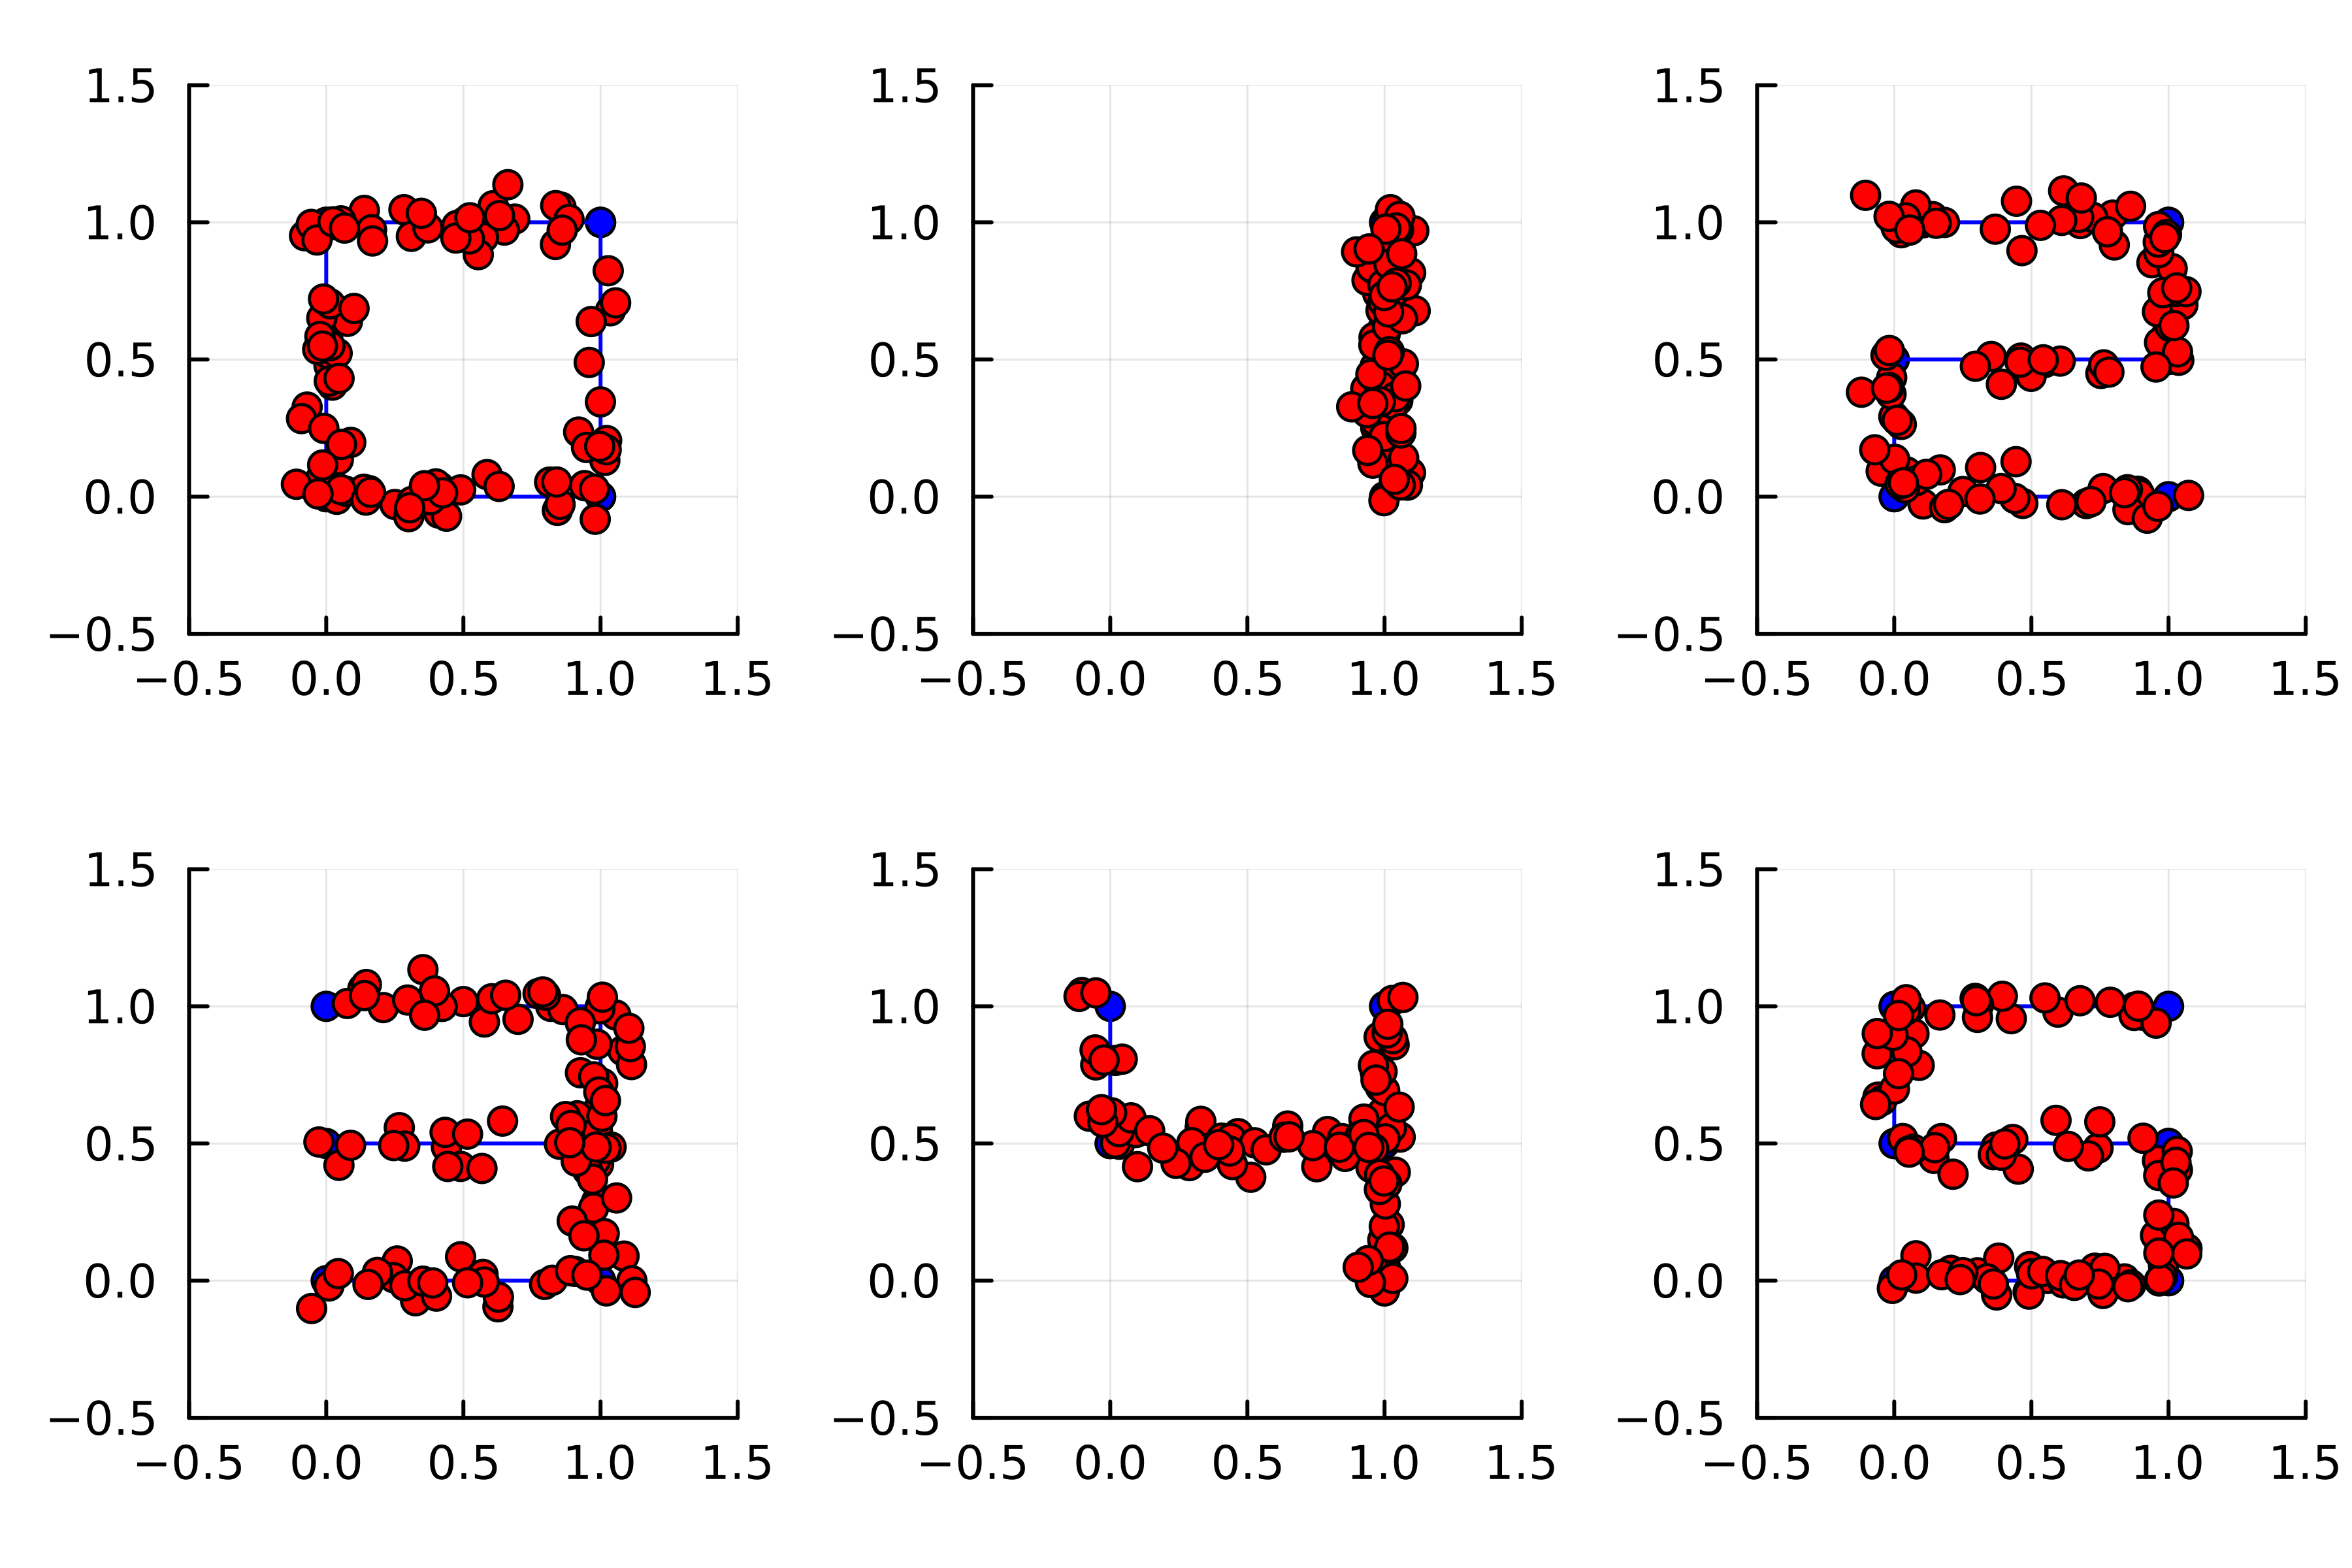

In [4]:
# Plot all digits with lines
plots = []

for number in 0:5
    digit = get_digit(number)
    obs_xs, obs_ys = sample_digit(digit, 100)

    p = Plots.scatter(digit.xs, digit.ys, markercolor="blue", legend=false, xlimits=(-0.5, 1.5), ylimits=(-0.5, 1.5),
    aspect_ratio=:equal)
    for line in 1:size(digit.lengths)[1]
        Plots.plot!([digit.xs[2*line-1], digit.xs[2*line]], [digit.ys[2*line-1], digit.ys[2*line]], color="blue", legend=false)
    end
    # Plots.plot!(digit.xs, digit.ys, color="blue", legend=false)
    Plots.scatter!(obs_xs, obs_ys, markercolor="red", legend=false, aspect_ratio=:equal)
    push!(plots, p)
end
plot(plots..., dpi=600)

### Do inference

Note that, like with the pixel method, this also does not work!

In [5]:
function do_inference(model, obs_xs, obs_ys, amount_of_computation)
    obs = Gen.choicemap()
    for i in 1:size(obs_xs)[1]
        obs[(:p_x, i)] = obs_xs[i]
        obs[(:p_y, i)] = obs_ys[i]
    end
    (trace, lml_est) = Gen.importance_resampling(model, (), obs, amount_of_computation)
    return trace, lml_est
end

do_inference (generic function with 1 method)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(

DynamicDSLFunction{Any}(Dict{Symbol, Any}

(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}

[], var"##number_model#293", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(

Dict{Any, Gen.ChoiceOrCallRecord}(

(:t, 15) => Gen.ChoiceOrCallRecord{Float64}(0.19890357297636307, -0.0, NaN, true), (:p_y, 87) => Gen.ChoiceOrCallRecord{Float64}(0.4236326508963323, -64.3630704822085, NaN, true), (:p_x, 9) => Gen.ChoiceOrCallRecord{Float64}(1.0255478101207003, -2.131170174478935, NaN, true), (:p_x, 74) => Gen.ChoiceOrCallRecord{Float64}(0.9391796658888536, -3.4499139301417574, NaN, true), (:p_y, 100) => Gen.ChoiceOrCallRecord{Float64}(0.4985689926531381, -47.63741434668364, NaN, true), (:p_x, 7) => Gen.ChoiceOrCallRecord{Float64}(0.9602352658491187, 1.979825556019097, NaN, true), (:p_y, 15) => Gen.ChoiceOrCallRecord{Float64}(0.5101093834717297, -49.96552288083232, NaN, true), (:t, 87) => Gen.ChoiceOrCallRecord{Float64}(0.756350034810232, -0.0, NaN, true), (:t, 68) => Gen.ChoiceOrCallRecord{Float64}(0.9751521018404264, -0.0, NaN, true), (:t, 24) => Gen.ChoiceOrCallRecord{Float64}(0.8596976951466007, -0.0, NaN, true), (:p_x, 65) => Gen.ChoiceOrCallRecord{Float64}(0.30257981705977455, -7.597862016092472,

Float64}(0.941499669092505, -2.892480295620224, NaN, true), (:p_y, 13) => Gen.ChoiceOrCallRecord{Float64}(0.46114541404877496, 1.7748579704610914, NaN, true), (:t, 4) => Gen.ChoiceOrCallRecord{Float64}(0.18156731199256815, -0.0, NaN, true), (:p_x, 78) => Gen.ChoiceOrCallRecord{Float64}(0.4555074656850076, -32.06255996511107, NaN, true), (:p_y, 63) => Gen.ChoiceOrCallRecord{Float64}(0.573778635284415, -18.43327275835587, NaN, true), (:t, 85) => Gen.ChoiceOrCallRecord{Float64}(0.8002031254579048, -0.0, NaN, true), (:p_x, 97) => Gen.ChoiceOrCallRecord{Float64}(0.5540690618549182, -37.69408657864123, NaN, true), (:p_y, 45) => Gen.ChoiceOrCallRecord{Float64}(0.7261851425903676, -8.155150005375665, NaN, true), (:p_y, 23) => Gen.ChoiceOrCallRecord{Float64}(0.015436016075069087, -191.796453948077, NaN, true), (:p_x, 4) => Gen.ChoiceOrCallRecord{Float64}(0.17966783829864102, -57.677826470653656, NaN, true), (:p_x, 35) => Gen.ChoiceOrCallRecord{Float64}(0.34985487670176063, -10.564250204474526, 

{Float64}(0.9695957366663077, -10.438658564997676, NaN, true), (:t, 7) => Gen.ChoiceOrCallRecord{Float64}(0.7455635923526492, -0.0, NaN, true), (:p_y, 37) => Gen.ChoiceOrCallRecord{Float64}(0.3269359795181002, -3.913437296722566, NaN, true), (:p_x, 62) => Gen.ChoiceOrCallRecord{Float64}(0.03424852211113575, -50.70837110246662, NaN, true), (:p_x, 13) => Gen.ChoiceOrCallRecord{Float64}(0.6345788950361759, -67.29789373646852, NaN, true), (:t, 61) => Gen.ChoiceOrCallRecord{Float64}(0.8924807531702741, -0.0, NaN, true), (:t, 74) => Gen.ChoiceOrCallRecord{Float64}(0.6932365701741656, -0.0, NaN, true), (:p_x, 38) => Gen.ChoiceOrCallRecord{Float64}(0.9961524884033279, -109.7591161031364, NaN, true), (:p_y, 1) => Gen.ChoiceOrCallRecord{Float64}(0.4288638500677504, 1.0647233749126195, NaN, true), (:t, 6) => Gen.ChoiceOrCallRecord{Float64}(0.5608741618137854, -0.0, NaN, true), (:p_x, 77) => Gen.ChoiceOrCallRecord{Float64}(0.5605271001389664, 1.8229062424409845, NaN, true), (:p_x, 85) => Gen.Choic

.ChoiceOrCallRecord{Float64}(0.4374219951949665, -26.125254697801953, NaN, true), (:p_x, 30) => Gen.ChoiceOrCallRecord{Float64}(0.9758702924191922, -4.703944748663526, NaN, true), (:p_y, 24) => Gen.ChoiceOrCallRecord{Float64}(0.7788083961542368, -7.708351382022888, NaN, true), (:p_x, 2) => Gen.ChoiceOrCallRecord{Float64}(0.9854415938210063, 2.0344043022548055, NaN, true), (:p_x, 31) => Gen.ChoiceOrCallRecord{Float64}(0.1999699449451957, 0.9018615717060867, NaN, true), (:p_y, 8) => Gen.ChoiceOrCallRecord{Float64}(0.4567298786868994, 1.7023330606592297, NaN, true), (:p_y, 42) => Gen.ChoiceOrCallRecord{Float64}(0.9358388182440265, 1.2534622914847042, NaN, true), (:t, 73) => Gen.ChoiceOrCallRecord{Float64}(0.8422581061635573, -0.0, NaN, true), (:p_x, 79) => Gen.ChoiceOrCallRecord{Float64}(0.0022277564903438836, -65.54572158919477, NaN, true), (:t, 16) => Gen.ChoiceOrCallRecord{Float64}(0.915410644986624, -0.0, NaN, true), (:t, 50) => Gen.ChoiceOrCallRecord{Float64}(0.8081071438861391, -0.0

(Any[0.9953895255196651, 0.9854415938210063, 0.8372494280290553, 0.17966783829864102, -0.04141789340962487, 1.007902363170111, 0.9602352658491187, 0.8998790031263836, 1.0255478101207003, 0.8670029684340333, 0.05006853448950236, 1.0439657103325948, 0.6345788950361759, 1.017010876473897, 1.01823122559665, 1.0273917309345109, -0.0934817198488162, 0.9725021769052742, 0.23661243185408304, 0.960470570287774, 0.9912954709059576, 0.9597111844984965, 1.028358060371203, 0.05175917083801294, 1.0176698849967665, 0.9109040578241044, 0.4561945362067307, 0.929692613127138, 0.0298111650262823, 0.9758702924191922, 0.1999699449451957, -0.014813210481547313, 0.5946644886429745, 0.774905952854137, 0.34985487670176063, 0.931126925198867, 0.9636266492354657, 0.9961524884033279, 0.9745500568200697, 0.040603414106552264, 0.8649038057953937, -0.05514628619354646, 0.8842203974704054, 0.9506755631136758, -0.009694575948880658, 0.5070875892276026, 0.8149335692961912, 0.3513845867591693, 0.30929889013568906, 0.087

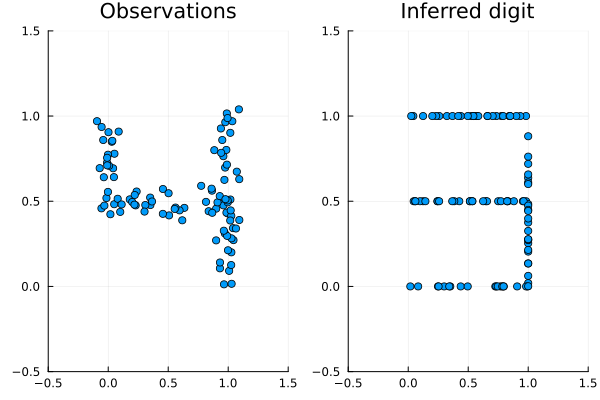

In [6]:
number = 4
constraints = Gen.choicemap()
constraints[(:number)] = number
trace, _ = Gen.generate(number_model, (), constraints)
obs_xs, obs_ys = Gen.get_retval(trace)


inference_trace, lml_est = do_inference(number_model, obs_xs, obs_ys, 10000)
println(inference_trace)


inf_ts = []
for i in 1:size(obs_xs)[1]
    push!(inf_ts, inference_trace[(:t, i)])
end

inf_xs = []
inf_ys = []
inferred_digit = get_digit(inference_trace[(:number)])
# inferred_digit = get_digit(number)  # DEBUG
for i in 1:size(inf_ts)[1]
    push!(inf_xs, sample_digit_t(inferred_digit, inf_ts[i])[1])
    push!(inf_ys, sample_digit_t(inferred_digit, inf_ts[i])[2])
end

println("Inferred number: ", inference_trace[(:number)])
println("ml_est: ", exp(lml_est))

p1 = Plots.scatter(obs_xs, obs_ys, legend=false, xlims=(-0.5,1.5), ylims=(-0.5,1.5), title="Observations")
p2 = Plots.scatter(inf_xs, inf_ys, legend=false, xlims=(-0.5,1.5), ylims=(-0.5,1.5), title="Inferred digit")
Plots.plot(p1, p2, layout=(1,2))